# Prediction of ICU mortality from patient parameters

This project is based on a dataset that was designed for Women in Data Science Datathon held in February 2020. The dataset provides information about ICU visits of more than 91,000 patients over a one-year timeframe from hundreds of hospitals all over the world. The aim is to create a model to predict the probability of death in ICU using patient parameters such as demographics, comorbidities, lab test results, vital signs, APACHE scores, and other statistics collected during the first 24 hours of ICU stay. An unlabeled dataset containing more than 39,000 samples is also provided to evaluate the performance of the classification model. In addition, a dictionary of features is available. The target variable is 'hospital_death' where 1 means death and 0 means survival.

I chose this dataset for my project because I expect it to be challenging since it comes from a global competition and it's also relevant to the theme of my systems biology master's program. My goal in this project is to implement data cleaning, preprocessing, and classification techniques to address the challenge of the Datathon.

# Import libraries and datasets

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
# read the training set and the unlabeled test set 
X_train = pd.read_csv("training_v2.csv")
unlabeled = pd.read_csv("unlabeled.csv")

print(X_train.shape)
print(unlabeled.shape)

(91713, 186)
(39308, 186)


In [3]:
# save encounter ids separately for the unlabeled dataset
unlabeled_encounter_id = unlabeled['encounter_id'] 

# drop features that are not expected to be related to the outcome (IDs are not meaningful and 
# readmission status contains all zeros)
X_train.drop(['hospital_id', 'patient_id', 'icu_id', 'readmission_status', 'encounter_id'], 
inplace=True, axis=1)
unlabeled.drop(['hospital_id', 'patient_id', 'icu_id', 'readmission_status', 'encounter_id'], 
inplace=True, axis=1)

print(X_train.shape)
print(unlabeled.shape)

(91713, 181)
(39308, 181)


In [4]:
# read the dictionary of features
dictionary_ = pd.read_csv("WiDS Datathon 2020 Dictionary.csv")
print(dictionary_.shape)

(188, 6)


In [5]:
# create separate lists of column names based on the data type of the columns
integer_cols = []
binary_cols = []
numeric_cols = []
string_cols = []

for i in range(dictionary_.shape[0]):
    if dictionary_.loc[i, 'Data Type'] == 'integer':
        integer_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'binary':
        binary_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'numeric':
        numeric_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'string':
        string_cols.append(dictionary_.loc[i, 'Variable Name'])

# Data Exploration

<ipython-input-6-603516e177e7>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


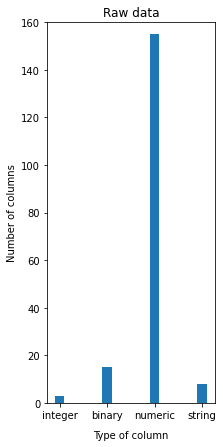

In [6]:
# find how many coiumns of each data type are present in the training dataset
integer_cols_X_train = []
binary_cols_X_train = []
numeric_cols_X_train = []
string_cols_X_train = []

for col_name in X_train.columns.to_list():
    if col_name in integer_cols:
        integer_cols_X_train.append(col_name)

    if col_name in binary_cols:
        binary_cols_X_train.append(col_name)    
    
    if col_name in numeric_cols:
        numeric_cols_X_train.append(col_name)

    if col_name in string_cols:
        string_cols_X_train.append(col_name)

# make a bar plot of column numbers vs type
fig, ax = plt.subplots(figsize=(3, 7))

ax.bar(['integer', 'binary', 'numeric', 'string'], [len(integer_cols_X_train), 
len(binary_cols_X_train), len(numeric_cols_X_train), len(string_cols_X_train)], width=0.2)
plt.xlabel('Type of column', labelpad=10)
plt.ylim(0, 160)
plt.ylabel('Number of columns')
plt.title('Raw data')

fig.show()        

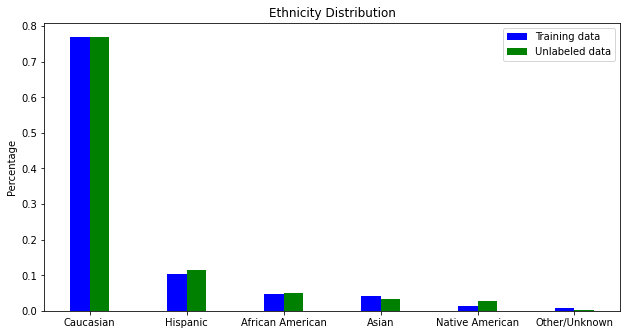

In [7]:
# make a bar plot of ethnicity distribution in the training and unlabeled datasets
cat_variable = 'ethnicity'
labels = list(X_train[cat_variable].dropna().unique())
x = np.arange(len(labels))
sizes_X = X_train[cat_variable].value_counts()/len(X_train)
sizes_unlabeled = unlabeled[cat_variable].value_counts()/len(unlabeled)
width = 0.2

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.bar(x - width/2, sizes_X, color = 'b', width=width, label='Training data')
ax.bar(x + width/2, sizes_unlabeled, color = 'g', width=width, label='Unlabeled data')

ax.set_ylabel('Percentage')
ax.set_title('Ethnicity Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=0)
plt.show()

# Step 1. Impute weight and height according to gender-wise mean values 

Height and weight are expected to be normally distributed in the population and majority of the people are expected to have a height and weight value that is close to the mean value of the population.

In [8]:
# impute height and weight with average values assuming that males are taller and heavier than females
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender == 'F')), 160, X_train["height"])
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender == 'M')), 180, X_train["height"])
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender.isna())), 170, X_train["height"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender == 'F')), 65, X_train["weight"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender == 'M')), 82, X_train["weight"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender.isna())), 74, X_train["weight"])

unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'F')), 160, unlabeled["height"])
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'M')), 180, unlabeled["height"])
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender.isna())), 170, unlabeled["height"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'F')), 65, unlabeled["weight"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'M')), 82, unlabeled["weight"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender.isna())), 74, unlabeled["weight"])

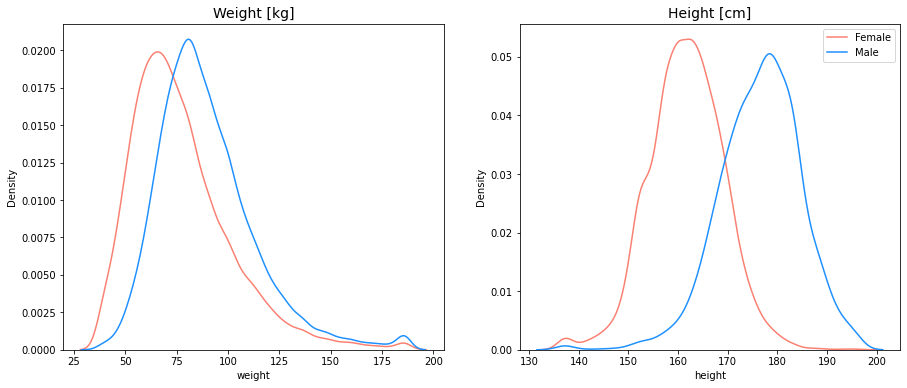

In [9]:
# Check that the distribution of height and weight in the population is approximately normal
# Plot univariate or bivariate distributions using kernel density estimation.
# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations 
# in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density 
# curve.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.kdeplot(X_train[X_train.gender == 'F'].weight, label='Female', color='salmon', ax=ax[0], bw_adjust=1.2,
legend=True)
sns.kdeplot(X_train[X_train.gender == 'M'].weight, label='Male', color='dodgerblue', ax=ax[0], bw_adjust=1.2,
legend=True)
ax[0].set_title('Weight [kg]', fontsize=14)

sns.kdeplot(X_train[X_train.gender == 'F'].height, label='Female', color='salmon', ax=ax[1], bw_adjust=1.8,
legend=True)
sns.kdeplot(X_train[X_train.gender == 'M'].height, label='Male', color='dodgerblue', ax=ax[1], bw_adjust=2,
legend=True)
ax[1].set_title('Height [cm]', fontsize=14)
plt.legend()
plt.show()

# Step 2. Drop features and samples containing more than 30% missing values 

This is done before imputation because it is difficult to impute higher percentage of missing values.

In [10]:
# find the number of missing values in each column and divide by column length
lst = X_train.isna().sum() / len(X_train)

# create a dataframe containing the percentage of missing values in each column
p = pd.DataFrame(lst)

# When we reset the index, the old index is added as a column, and a new sequential index is used
p.reset_index(inplace=True)

# find columns containing more than 30% missing values
p.columns = ['a', 'b']
low_count = p[p['b'] > 0.3]
todelete = low_count['a'].values

# drop columns containing more than 30% missing values from the training and unlabeled datasets
X_train.drop(todelete, axis=1, inplace=True)
unlabeled.drop(todelete, axis=1, inplace=True)

print(X_train.shape)
print(unlabeled.shape)

(91713, 107)
(39308, 107)


<ipython-input-11-ddf718b405c0>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


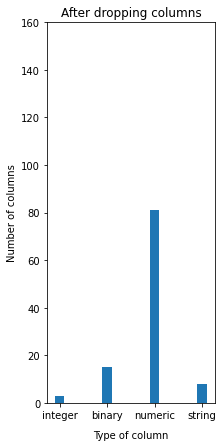

In [11]:
# find how many coiumns of each data type are present in the training dataset
integer_cols_X_train = []
binary_cols_X_train = []
numeric_cols_X_train = []
string_cols_X_train = []

for col_name in X_train.columns.to_list():
    if col_name in integer_cols:
        integer_cols_X_train.append(col_name)

    if col_name in binary_cols:
        binary_cols_X_train.append(col_name)    
    
    if col_name in numeric_cols:
        numeric_cols_X_train.append(col_name)

    if col_name in string_cols:
        string_cols_X_train.append(col_name)

# make a bar plot of column numbers vs type
fig, ax = plt.subplots(figsize=(3, 7))

ax.bar(['integer', 'binary', 'numeric', 'string'], [len(integer_cols_X_train), 
len(binary_cols_X_train), len(numeric_cols_X_train), len(string_cols_X_train)], width=0.2)
plt.ylim(0, 160)
plt.xlabel('Type of column', labelpad=10)
plt.ylabel('Number of columns')
plt.title('After dropping columns')

fig.show() 

In [12]:
# drop rows ontaining more than 30% missing values from the training dataset
X_train.dropna(thresh=X_train.shape[1]*0.3, inplace=True)
X_train.shape

(91677, 107)

# Plot distributions of numeric features to find any observable differences between training and unlabeled datasets

<AxesSubplot:>

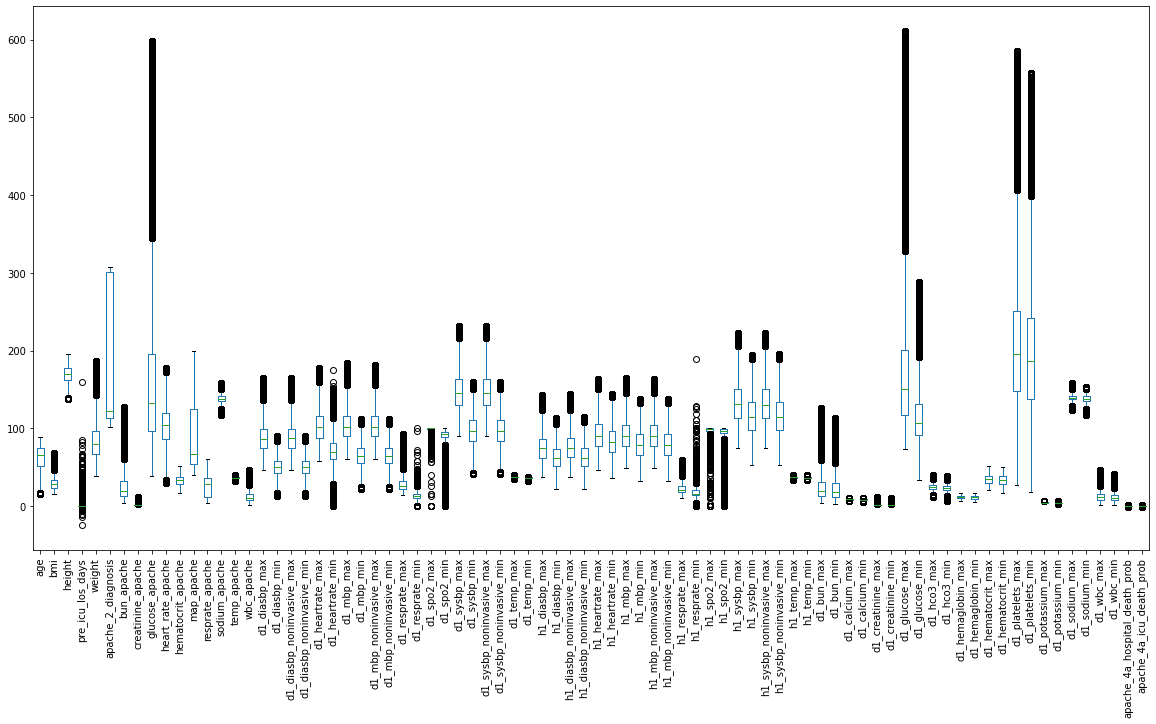

In [13]:
# Remove 'apache_3j_diagnosis' because its distribution is deviating a lot from the rest
n = numeric_cols_X_train.copy()
n.remove('apache_3j_diagnosis')

# make a box plot of the distributions of the remaining features of the training dataset
X_train.boxplot(column=n, ax=None, 
fontsize=None, rot=90, grid=False, figsize=(20, 10), layout=None)

<AxesSubplot:>

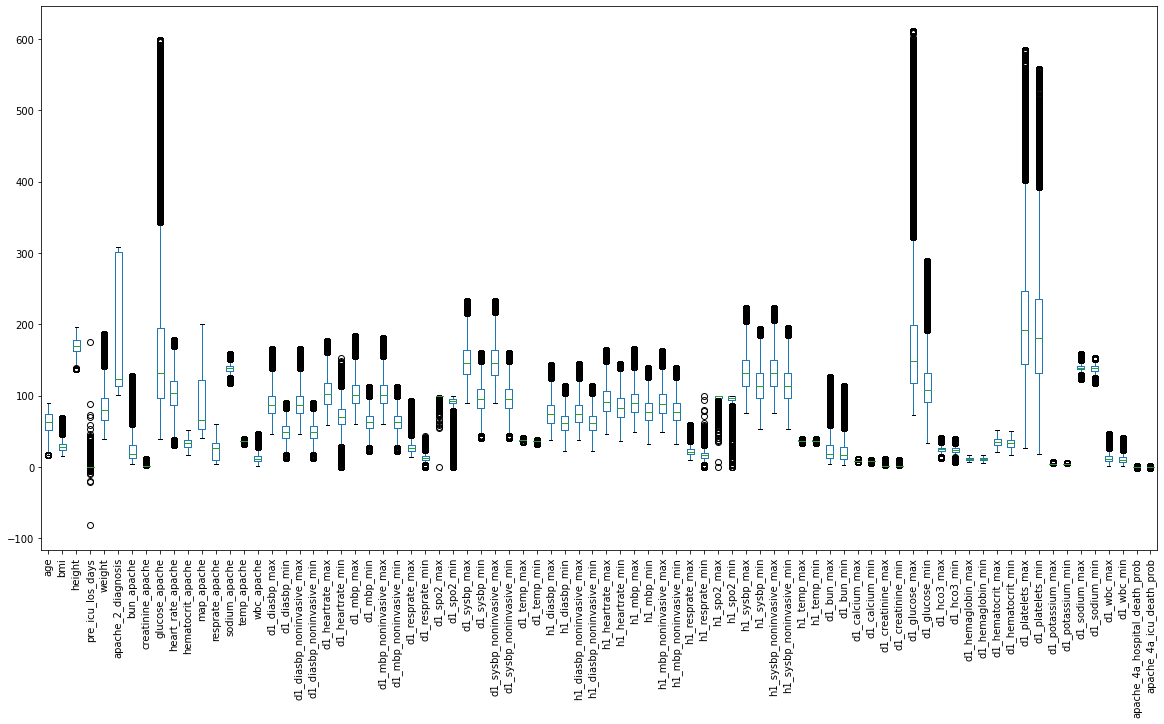

In [14]:
# make a box plot of the distributions of the remaining features of the unlabeled dataset
unlabeled.boxplot(column=n, ax=None, 
fontsize=None, rot=90, grid=False, figsize=(20,10), layout=None)

The plotted distributions show no observable dfferences.

# Step 3. Encode string features as ordinal integers

Encoding is needed because classifiers cannot handle data in string format. There are two ways to encode string features: ordinal encoding and one-hot encoding.

I have chosen ordinal encoding because
* One-hot encoding increases the number of features and that would increase my computational load
* Random forest algorithm that I am planning to use is not affected by the ordinal nature of the features

Before ordinal encoding can be done, empty boxes in the string columns have to be replaced with 'None'.

In [15]:
# for string columns, replace empty boxes with "None"
for col_name in string_cols:
    if col_name in X_train.columns.to_list():
        X_train[col_name].where(pd.notnull(X_train[col_name]), None, inplace=True)

    if col_name in unlabeled.columns.to_list():
        unlabeled[col_name].where(pd.notnull(unlabeled[col_name]), None, inplace=True)

In [16]:
from sklearn.preprocessing import OrdinalEncoder

# define ordinal encoder
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

# fit the encoder on the training dataset and transform the training and unlabeled datasets
for col_name in string_cols:
    if col_name in X_train.columns.to_list():
        enc.fit(X_train[[col_name]])
        X_train[col_name] = enc.transform(X_train[[col_name]])

    if col_name in unlabeled.columns.to_list():
        unlabeled[col_name] = enc.transform(unlabeled[[col_name]])

In [17]:
# convert the data types of all columns to float 
X_train = X_train.astype('float32')
unlabeled = unlabeled.astype('float32')

print(X_train.shape)
print(unlabeled.shape)

(91677, 107)
(39308, 107)


# Step 4. Impute missing values with k nearest neighbors

K nearest neighbors imputation is an algorithm in which missing values are imputed using the mean value from k nearest neighbors. I chose this algorithm because patients with similar conditions are expected to have similar parameters as well. Other reasons are
* Features in my dataset have different data types and KNN can handle this problem
* Real distribution of features in my dataset is unknown and KNN does not require this information to be able to provide reasonable results

In [18]:
from sklearn.impute import KNNImputer

# define KNN Imputer
# neighbors = 5, weighted by the inverse of their distance, metric: NAN Euclidean
# NAN Euclidean metric: ignores feature coordinates with a missing value and scales up 
# the weight of the remaining coordinates
knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='distance', metric='nan_euclidean', 
copy=False)

# fit the imputer on the training dataset
knn_imputer.fit(X_train)

# after fitting the imputer on the training dataset only, transform the training and unlabeled datasets
knn_imputer.transform(X_train)
knn_imputer.transform(unlabeled)

KNNImputer(copy=False, weights='distance')

In [21]:
# save the processed data as csv files
X_train.to_pickle("X_train_knn.csv")
unlabeled.to_pickle("unlabeled_knn.csv")

In [9]:
# read the processed data from csv files
X_train = pd.read_pickle("X_train_knn.csv")
unlabeled = pd.read_pickle("unlabeled_knn.csv")

# Step 5. Remove highly correlated features

It is good to remove highly correlated features because
* It reduces computational expense; less features mean a smaller dataset
* Correlated features may reduce performance of some classification algorithms

In [22]:
# create a list of names of the numeric columns
num_feature = []

for col_name in numeric_cols:
    if col_name in X_train.columns.to_list():
        num_feature.append(col_name)

# create a correlation matrix of numeric columns 
corr_matrix = X_train[num_feature].corr().abs()

<AxesSubplot:>

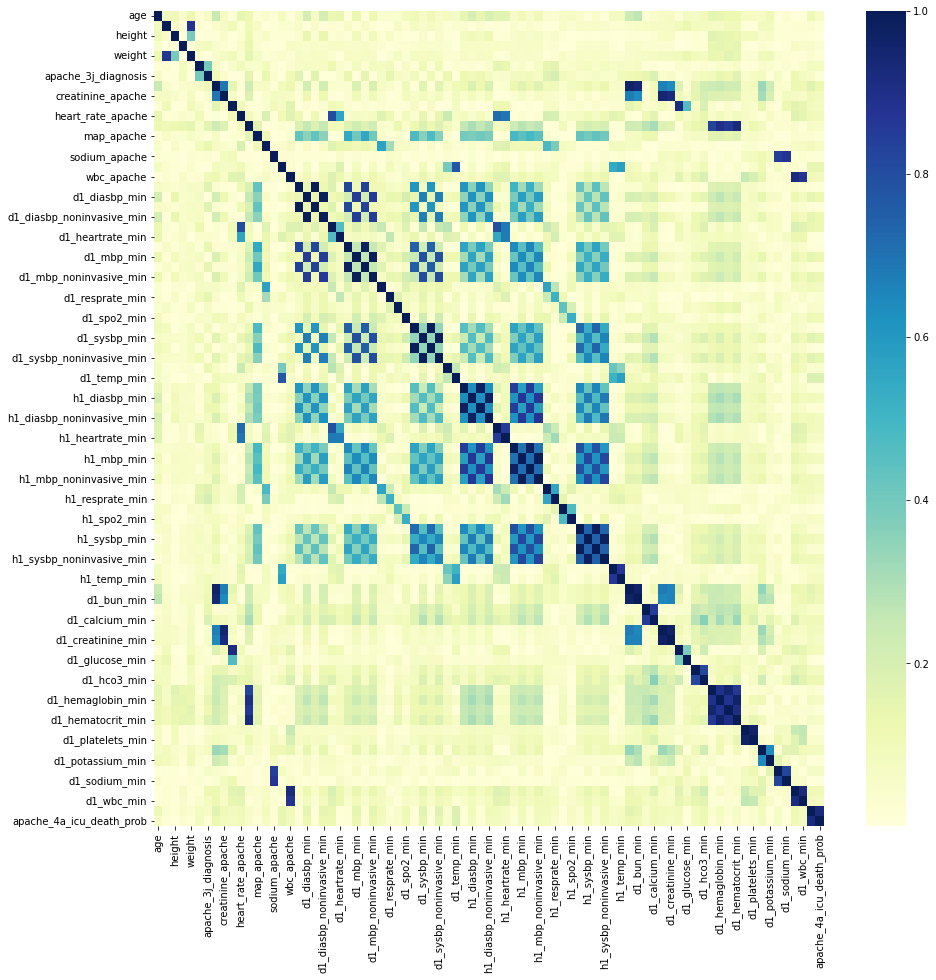

In [23]:
# create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap="YlGnBu")

In [24]:
# select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

Text(0, 0.5, 'number of columns to drop')

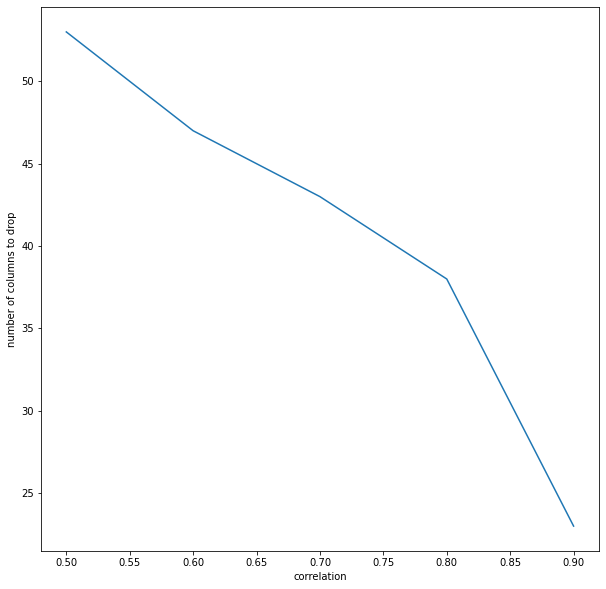

In [25]:
# plot a graph of number of columns to drop vs correlation
corr = []
to_drop_columns = []

for i in np.arange(0.5, 1, 0.1):
    to_drop = [column for column in upper.columns if any(upper[column] > i)]
    corr.append(i)
    to_drop_columns.append(len(to_drop))

plt.subplots(figsize=(10, 10))
plt.plot(corr, to_drop_columns)
plt.xlabel('correlation')
plt.ylabel('number of columns to drop')

In [26]:
# A correlation threshold of 80% is chosen because this threshold removes most correlation without 
# removing too many features.

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop columns that have more than 80% correlation to other columns
X_train.drop(to_drop, inplace=True, axis=1)
unlabeled.drop(to_drop, inplace=True, axis=1)

# Check dimensions after removing correlated columns
print(X_train.shape)
print(unlabeled.shape)

(91677, 69)
(39308, 69)


<ipython-input-27-7f5733e9d0ca>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


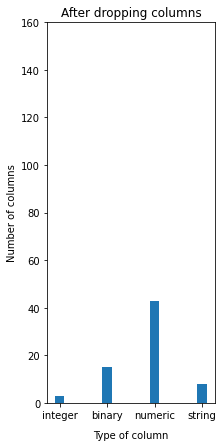

In [27]:
# find how many coiumns of each data type are present in the training dataset
integer_cols_X_train = []
binary_cols_X_train = []
numeric_cols_X_train = []
string_cols_X_train = []

for col_name in X_train.columns.to_list():
    if col_name in integer_cols:
        integer_cols_X_train.append(col_name)

    if col_name in binary_cols:
        binary_cols_X_train.append(col_name)    
    
    if col_name in numeric_cols:
        numeric_cols_X_train.append(col_name)

    if col_name in string_cols:
        string_cols_X_train.append(col_name)

# make a bar plot of column numbers vs type
fig, ax = plt.subplots(figsize=(3, 7))

ax.bar(['integer', 'binary', 'numeric', 'string'], [len(integer_cols_X_train), 
len(binary_cols_X_train), len(numeric_cols_X_train), len(string_cols_X_train)], width=0.2)
plt.ylim(0, 160)
plt.xlabel('Type of column', labelpad=10)
plt.ylabel('Number of columns')
plt.title('After dropping columns')

fig.show()

# Step 6. Remove outliers

Outlier removal is important because outliers might affect classifier training. I chose the isolation forest algorithm to implement this step because
* Features in my dataset have different data types and the isolation forest algorithm can handle this problem
* Real distribution of features is unknown and the isolation forest does not require this information to be able to provide reasonable results
* There is no need to scale the data first for the isolation forest to be able to identify outliers

In [29]:
from sklearn.ensemble import IsolationForest

# Define isolation forest
# n_estimators: The number of base estimators in the ensemble.
# max_samples: The number of samples to draw from X to train each base estimator.
# contamination: The proportion of outliers in the data set.
# max_features: The number of features to draw from X to train each base estimator.
# n_jobs: The number of jobs to run in parallel. 
iso = IsolationForest(n_estimators=1000, max_samples=1000, contamination='auto', max_features=10, 
n_jobs=-1, random_state=20)

# Fit isolation forest on the training dataset
iso.fit(X_train)

# Find anomaly scores for each sample in the training dataset
# Negative scores correspond to anomalies - the more negative the more anomalous
scores = iso.decision_function(X_train)

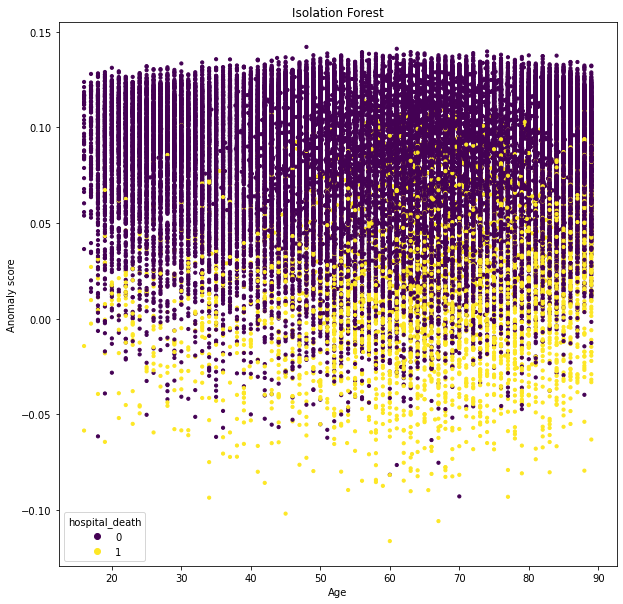

In [30]:
# Make a scatter plot of anomaly scores versus age and color by 'hospital_death'
plt.subplots(figsize=(10, 10))
plt.title("Isolation Forest")

b = plt.scatter(X_train['age'], scores, c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('Age')
plt.ylabel('Anomaly score')
plt.show()

In [31]:
# Add the anomaly scores to the training data matrix as an additional column
X_train_scores = X_train
X_train_scores['scores'] = scores

# Drop samples that have a score of less than -0.01 and a 'hospital_death' value of 0
# This is done because there is a low density of points below -0.01 as observed from the plot
# Only the 'hospital_death' = 0 samples are dropped because 'hospital_death' = 1 samples are 
# already very few in the dataset and most of them have negative anomaly scores 
indexes_to_drop = X_train_scores[(X_train_scores['scores'] < -0.01) & 
(X_train_scores['hospital_death'] == 0.0)].index

# Drop the outliers from the training dataset
X_train_scores.drop(indexes_to_drop, inplace=True)
scores = X_train_scores['scores']
X_train = X_train_scores.drop(['scores'], axis=1)

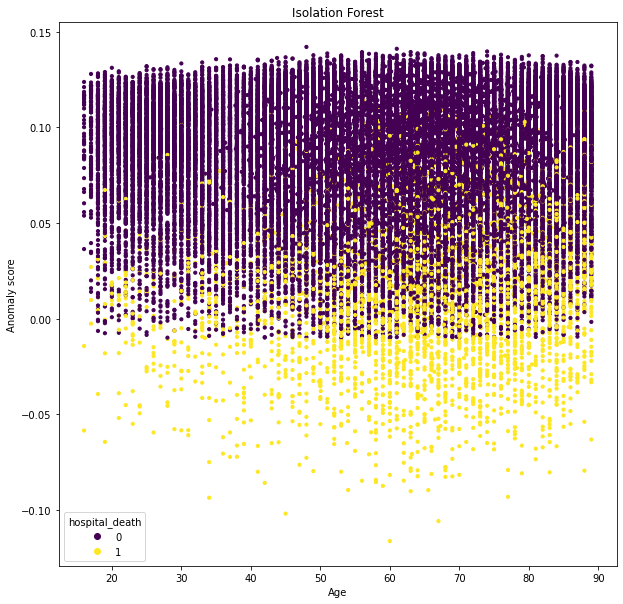

In [32]:
# Make a scatter plot of anomaly scores versus age and color by 'hospital_death'
plt.subplots(figsize=(10, 10))
plt.title("Isolation Forest")

b = plt.scatter(X_train['age'], scores, c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('Age')
plt.ylabel('Anomaly score')
plt.show()

In [33]:
# Check dimensions after dropping outliers
print(X_train.shape)
print(unlabeled.shape)

(91311, 69)
(39308, 69)


# Step 7. Range scaling

Scaling the dataset is needed for PCA. Scaling is done with Min Max Scaler algorithm which scales and translates each feature such that it is in the range between zero and one. I have chosen this algorithm because
* Features in my dataset have different data types and the isolation forest algorithm can handle this problem
* Real distribution of features is unknown and the isolation forest does not require this information to be able to provide reasonable results

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Define Min Max Scaler
scalar = MinMaxScaler()

# Fit the scaler on the training dataset
scalar.fit(X_train)

# Transform the training and unlabeled datasets using the fitted scaler
X_train_scaled = pd.DataFrame(scalar.transform(X_train), columns=X_train.columns)
unlabeled_scaled = pd.DataFrame(scalar.transform(unlabeled), columns=unlabeled.columns)

In [35]:
# save the processed data as csv files
X_train_scaled.to_pickle("X_train_scaled.csv")
unlabeled_scaled.to_pickle("unlabeled_scaled.csv")

In [21]:
# read the processed data from csv files
X_train_scaled = pd.read_pickle("X_train_scaled.csv")
unlabeled_scaled = pd.read_pickle("unlabeled_scaled.csv")

# Step 8. Principal Component Analysis (PCA)

PCA is useful for observing the main sources of variance in the data.

In [36]:
from sklearn.decomposition import PCA

# Define PCA
pca = PCA(random_state=20)

# Fit and transform the training dataset
components = pca.fit_transform(X_train_scaled)

<ipython-input-37-7b4019318a98>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


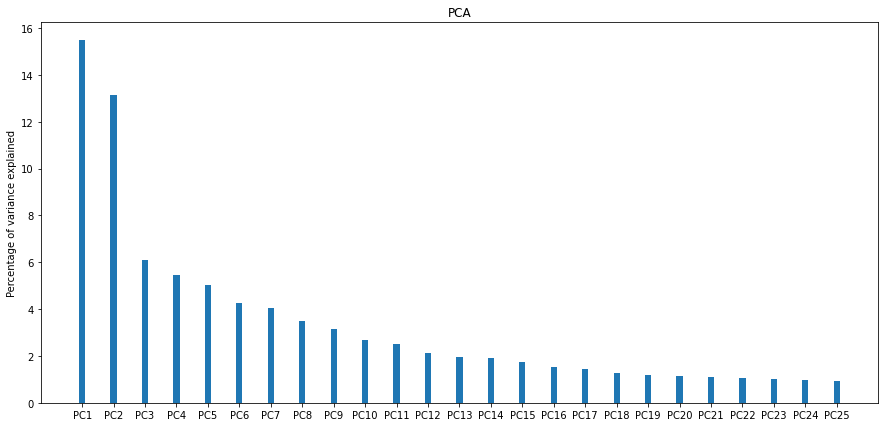

In [37]:
# Plot the percentage of variance explained for each PC
fig, ax = plt.subplots(figsize=(15, 7))

ax.bar([f"PC{i+1}" for i in range(25)], pca.explained_variance_ratio_[0:25]*100, width=0.2)
plt.ylabel('Percentage of variance explained')
plt.title('PCA')

fig.show()

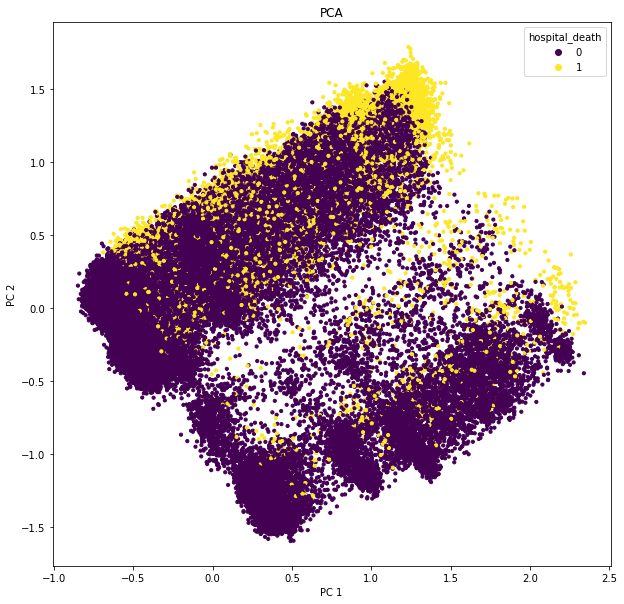

In [38]:
# Make a plot of PC 2 versus PC 1 and color the points by 'hospital_death' 
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,0], components[:,1], c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

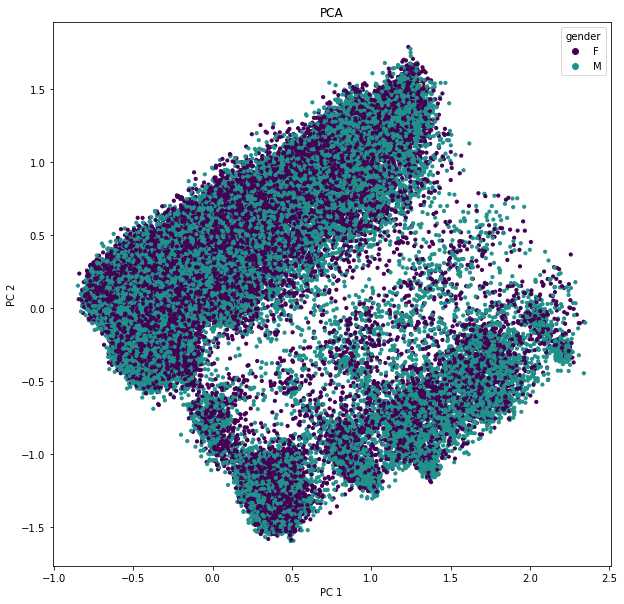

In [39]:
# Make a plot of PC 2 versus PC 1 and color the points by 'gender' 
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,0], components[:,1], c=X_train['gender'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=('F','M'), title="gender")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

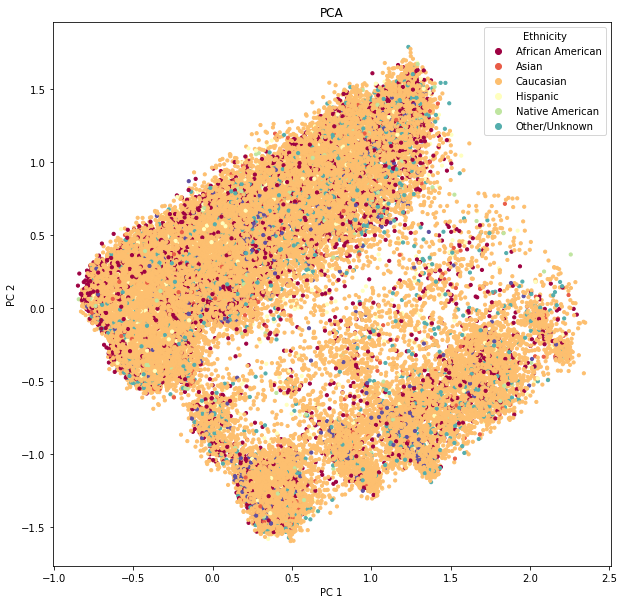

In [40]:
# Make a plot of PC 2 versus PC 1 and color the points by 'ethnicity' 
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,0], components[:,1], c=X_train['ethnicity'].astype('int32'), s=10, 
cmap="Spectral")

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=('African American','Asian',
'Caucasian','Hispanic','Native American','Other/Unknown'), title="Ethnicity")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# Step 9. Augment data to overcome class imbalance

The training dataset contains a lot more samples where 'hospital_death' = 0 compared to those where 'hospital_death' = 1 and this might result in a bias when training the classifier. Therefore, this class imbalance problem has to be resolved by data augmentation before the classifier can be trained. 

In [41]:
# extract the 'hospital_death' column from the training dataset and store it separately as a vector
y_train = X_train['hospital_death']
X_train.drop('hospital_death', inplace=True, axis=1)
unlabeled.drop('hospital_death', inplace=True, axis=1)

# find the proportion of positive and non-positive targets in the label vector
y_train.value_counts() / len(y_train)

0.0    0.913384
1.0    0.086616
Name: hospital_death, dtype: float64

In [42]:
# make a list of column names that are categorical
# all columns that are not numeric are categorical
cat_feature = []

for i, col_name in enumerate(X_train.columns.to_list()):
    if col_name not in numeric_cols:
        cat_feature.append(i)

In [43]:
# Before doing data augmentation, the training dataset has to be split up into 8 smaller subsets 
# because my computer memory is not big enough to handle the augmentation of the dataset altogether 

# train_test_split is a function that splits the dataset into two smaller subsets and it can be used
# to create subsets before data augmentation
# in the following, test_size=0.5 which means the two smaller subsets are created equal in size
# in the following, stratify=y_train which means the two smaller subsets contain equal proporotions of 
# positive and non-positive targets

from sklearn.model_selection import train_test_split

X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, 
random_state=20)
X_train11, X_train21, y_train11, y_train21 = train_test_split(X_train1, y_train1, test_size=0.5, 
stratify=y_train1, random_state=20)
X_train12, X_train22, y_train12, y_train22 = train_test_split(X_train2, y_train2, test_size=0.5, 
stratify=y_train2, random_state=20)
X_train111, X_train211, y_train111, y_train211 = train_test_split(X_train11, y_train11, test_size=0.5, 
stratify=y_train11, random_state=20)
X_train121, X_train221, y_train121, y_train221 = train_test_split(X_train21, y_train21, test_size=0.5, 
stratify=y_train21, random_state=20)
X_train112, X_train212, y_train112, y_train212 = train_test_split(X_train12, y_train12, test_size=0.5, 
stratify=y_train12, random_state=20)
X_train122, X_train222, y_train122, y_train222 = train_test_split(X_train22, y_train22, test_size=0.5, 
stratify=y_train22, random_state=20)

The Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC) algorithm is used to perform data augmentation. It is a method which oversamples the minority class and increases the number of samples in the minority class until they become equal to the number of samples in the majority class. It works as follows:
* Find k nearest neighbors of a sample from the minority class. 
* Randomly select one neighbor from the k nearest neighbors and create a synthetic sample at a randomly selected point between the two samples. 
* The categorical features of the synthetic sample are decided by picking the most frequent categorical features of the nearest neighbors.

I have chosen the SMOTE-NC algorithm to do data augmentation because:
* Features in my dataset have different data types and the SMOTE-NC algorithm can handle this problem
* Real distribution of features is unknown and the SMOTE-NC algorithm does not require this information to be able to provide reasonable results

In [44]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(categorical_features=cat_feature, n_jobs=-1, random_state=20)

X_train111, y_train111 = sm.fit_resample(X_train111, y_train111)
X_train211, y_train211 = sm.fit_resample(X_train211, y_train211)
X_train121, y_train121 = sm.fit_resample(X_train121, y_train121)
X_train221, y_train221 = sm.fit_resample(X_train221, y_train221)
X_train112, y_train112 = sm.fit_resample(X_train112, y_train112)
X_train212, y_train212 = sm.fit_resample(X_train212, y_train212)
X_train122, y_train122 = sm.fit_resample(X_train122, y_train122)
X_train222, y_train222 = sm.fit_resample(X_train222, y_train222)

In [45]:
print(y_train111.value_counts() / len(y_train111))
print(y_train211.value_counts() / len(y_train211))
print(y_train121.value_counts() / len(y_train121))
print(y_train221.value_counts() / len(y_train221))
print(y_train112.value_counts() / len(y_train112))
print(y_train212.value_counts() / len(y_train212))
print(y_train122.value_counts() / len(y_train122))
print(y_train222.value_counts() / len(y_train222))

0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64


In [46]:
X_train = pd.concat([X_train111, X_train211, X_train121, X_train221, 
X_train112, X_train212, X_train122, X_train222])
y_train = pd.concat([y_train111, y_train211, y_train121, y_train221, 
y_train112, y_train212, y_train122, y_train222])

print(X_train.shape)
print(y_train.shape)

(166804, 68)
(166804,)


In [47]:
X_train.to_pickle("X_train_smote.csv")
unlabeled.to_pickle("unlabeled_smote.csv")
y_train.to_pickle("y_train_smote.csv")

In [7]:
X_train = pd.read_pickle("X_train_smote.csv")
y_train = pd.read_pickle("y_train_smote.csv")
unlabeled = pd.read_pickle("unlabeled_smote.csv")

In [41]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier = RandomForestClassifier(random_state=20)

n_estimators = [1500]

min_samples_split = [20, 50, 100]

# 5-fold cross-validation 
cv = StratifiedKFold(n_splits=5)

grid = dict(n_estimators=n_estimators, min_samples_split=min_samples_split)

# GridSearchCV exhaustively generates candidates from a grid of parameter values
grid_search = GridSearchCV(estimator=RF_classifier, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', 
error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# define a Random Forest model using the optimal parameter values obtained from the grid search
RF_classifier = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                min_samples_split=grid_result.best_params_['min_samples_split'],
                random_state=20)

Best: 0.902262 using {'min_samples_split': 20, 'n_estimators': 1500}


In [48]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier = RandomForestClassifier(n_estimators=1500, min_samples_split=20, random_state=20)
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=20, n_estimators=1500, random_state=20)

In [49]:
sorted_idx = RF_classifier.feature_importances_.argsort()

Text(0.5, 0, 'Random Forest Feature Importance')

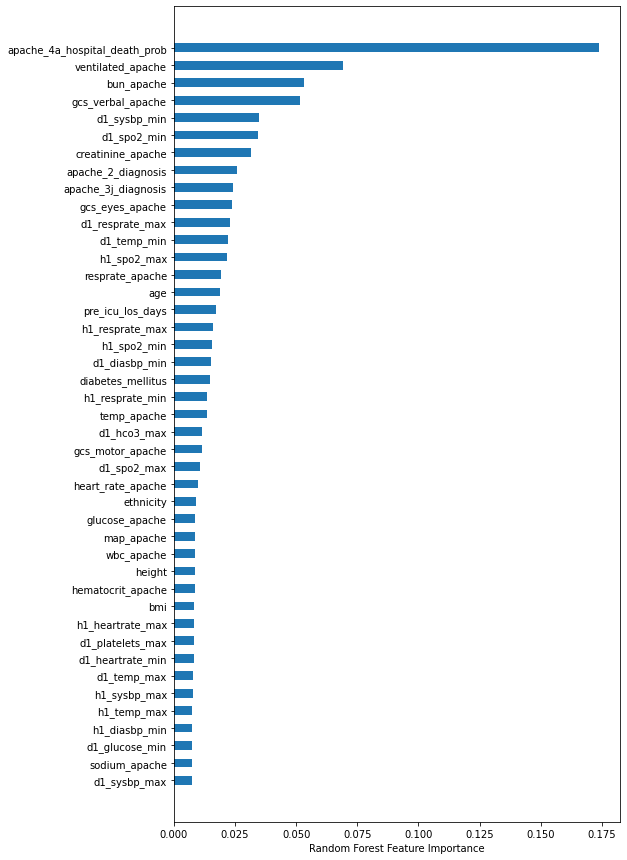

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,15))
plt.barh(X_train.columns[sorted_idx[25:68]], RF_classifier.feature_importances_[sorted_idx[25:68]], 
height=0.5)
plt.xlabel("Random Forest Feature Importance")

In [51]:
prob = RF_classifier.predict_proba(unlabeled)[:,1]

submission = pd.DataFrame({'encounter_id': unlabeled_encounter_id.astype(int), 'hospital_death': prob})

print(len(prob))
print(len(unlabeled_encounter_id))

39308
39308


In [13]:
submission.to_csv("submission.csv", index=False)